In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190723_1255.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [4]:
DIR = "/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/"
BSDIR = "/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 21 files in the folder /das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/


In [5]:
filename = "Ru_foil_monoscan_001_step0019.JF02T09V02crop.h5"
bsreadfile = "Ru_foil_monoscan_001_step0019.BSREAD.h5"

images_LB1_Si, pulse_ids_LB1_Si = load_JF_cropped_data(DIR + filename, 1)
images_LA1_Si, pulse_ids_LA1_Si = load_JF_cropped_data(DIR + filename, 2)
images_LB2_Q, pulse_ids_LB2_Q = load_JF_cropped_data(DIR + filename, 3)
images_LB1_Q, pulse_ids_LB1_Q = load_JF_cropped_data(DIR + filename, 4)

(DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, BS_pulse_ids_pump, BS_pulse_ids_unpump, _, _) = \
         load_PumpProbe_events(BSDIR+bsreadfile, channel_BS_pulse_ids)
    


images_roi1
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
images_roi3
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
images_roi4
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>


In [6]:
nframes = images_LB1_Si.shape[0]

numstds = 2
minIzero = 0.002
image_threshold = 0
hot_pixel = 100

total_LB1_Si = 0
total_LA1_Si = 0
total_LB2_Q = 0
total_LB1_Q = 0

IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_pump]))
IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_pump]))

for i in range(nframes):
    
    conditionPumpMax = IzeroFEL_pump[i] < IzeroMedian+numstds*IzeroSTD
    conditionPumpMin = IzeroFEL_pump[i] > IzeroMedian-numstds*IzeroSTD
    conditionPumpLow = IzeroFEL_pump[i] > minIzero
    
    #if conditionPumpMax and conditionPumpMin and conditionPumpLow:
    if True:

        image_LB1_Si = images_LB1_Si[i, :]
        image_thr_LB1_Si = image_LB1_Si.copy()
        image_thr_LB1_Si[image_LB1_Si < image_threshold] = 0
        image_thr_LB1_Si[image_LB1_Si > hot_pixel] = 0
        total_LB1_Si += image_thr_LB1_Si
        
        image_LA1_Si = images_LA1_Si[i, :]
        image_thr_LA1_Si = image_LA1_Si.copy()
        image_thr_LA1_Si[image_LA1_Si < image_threshold] = 0
        image_thr_LA1_Si[image_LA1_Si > hot_pixel] = 0
        total_LA1_Si += image_thr_LA1_Si
        
        image_LB2_Q = images_LB2_Q[i, :]
        image_thr_LB2_Q = image_LB2_Q.copy()
        image_thr_LB2_Q[image_LB2_Q < image_threshold] = 0
        image_thr_LB2_Q[image_LB2_Q > hot_pixel] = 0
        total_LB2_Q += image_thr_LB2_Q
        
        image_LB1_Q = images_LB1_Q[i, :]
        image_thr_LB1_Q = image_LB1_Q.copy()
        image_thr_LB1_Q[image_LB1_Q < image_threshold] = 0
        image_thr_LB1_Q[image_LB1_Q > hot_pixel] = 0
        total_LB1_Q += image_thr_LB1_Q

print(total_LB1_Q.shape)


(512, 300)


<IPython.core.display.Javascript object>


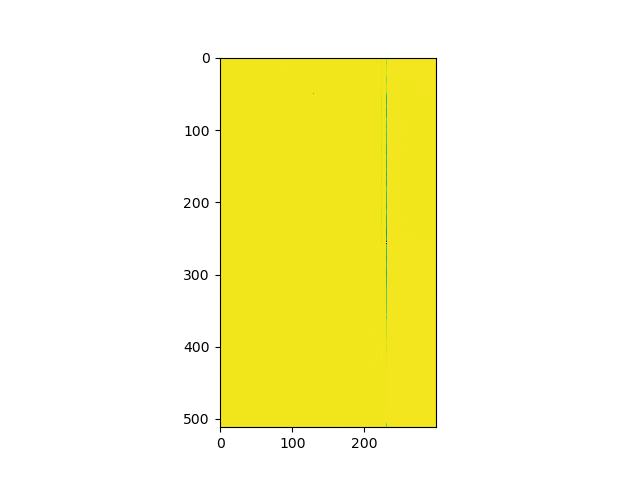

In [7]:
with h5py.File(DIR+filename, "r") as f:

    images    = f["images_roi2"][:None]

plt.figure()
plt.imshow(images.sum(0))

<IPython.core.display.Javascript object>


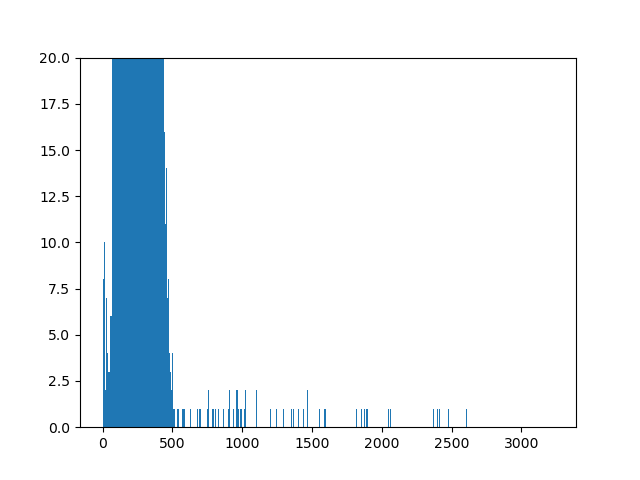

(0, 20)

In [8]:
plt.figure()
_ = plt.hist(total_LB1_Q.ravel(),1000)
plt.ylim([0,20])

188.6295
3230.1248


<IPython.core.display.Javascript object>


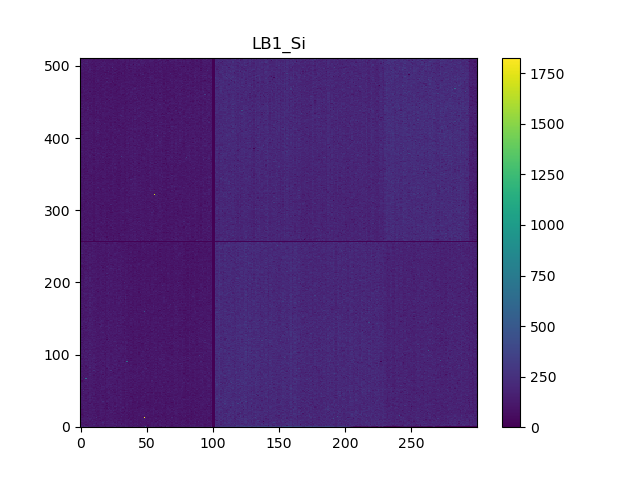

<IPython.core.display.Javascript object>


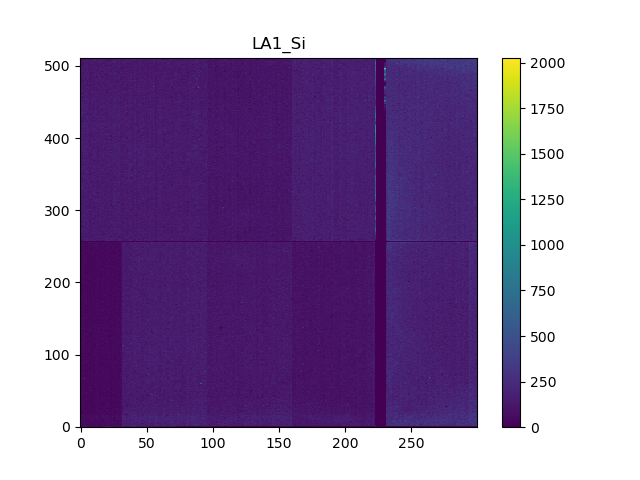

<IPython.core.display.Javascript object>


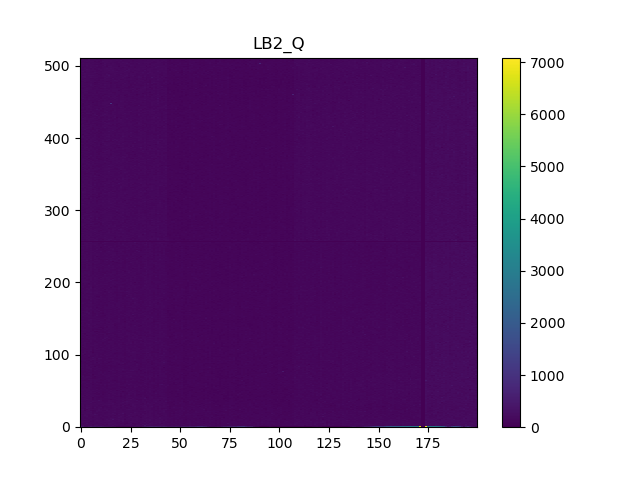

<IPython.core.display.Javascript object>


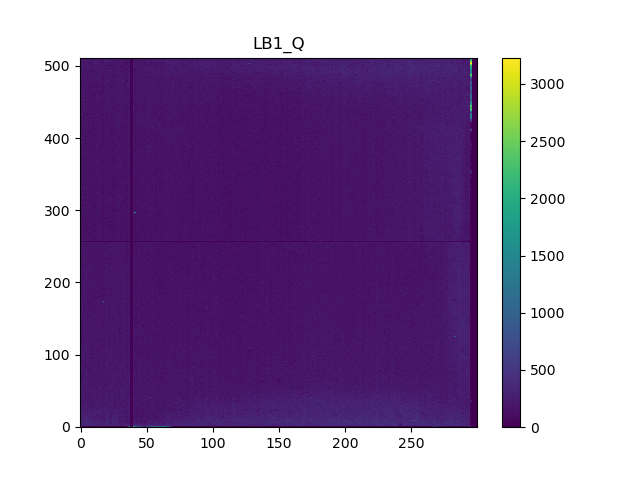

In [9]:
print(np.mean(np.ndarray.flatten(total_LB1_Q)))
print(max(np.ndarray.flatten(total_LB1_Q)))

plt.figure()
plt.imshow(total_LB1_Si, origin="lower", aspect='auto')
plt.colorbar()
plt.title('LB1_Si')
plt.show()

plt.figure()
plt.imshow(total_LA1_Si, origin="lower", aspect='auto')
plt.colorbar()
plt.title('LA1_Si')
plt.show()

plt.figure()
plt.imshow(total_LB2_Q, origin="lower", aspect='auto')
plt.colorbar()
plt.title('LB2_Q')
plt.show()

plt.figure()
plt.imshow(total_LB1_Q, origin="lower", aspect='auto')
plt.colorbar()
plt.title('LB1_Q')
plt.show()


300
(512, 300)


<IPython.core.display.Javascript object>


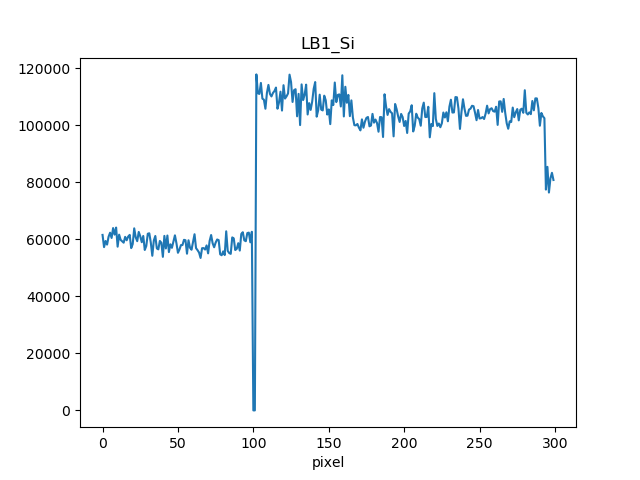

<IPython.core.display.Javascript object>


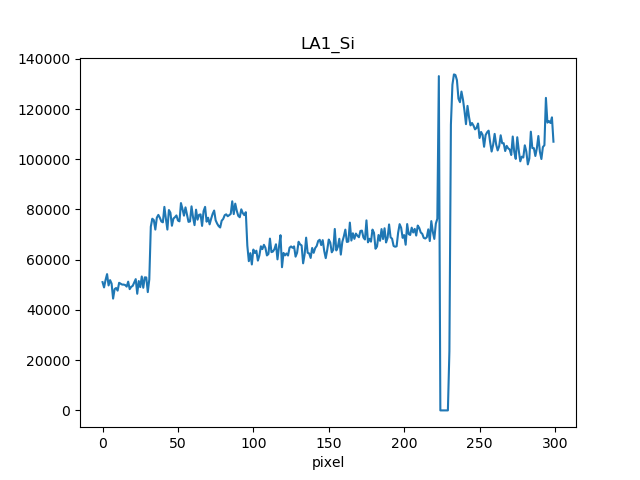

<IPython.core.display.Javascript object>


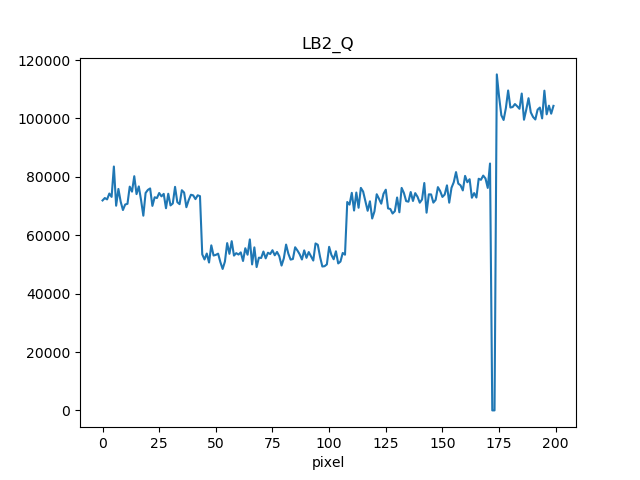

<IPython.core.display.Javascript object>


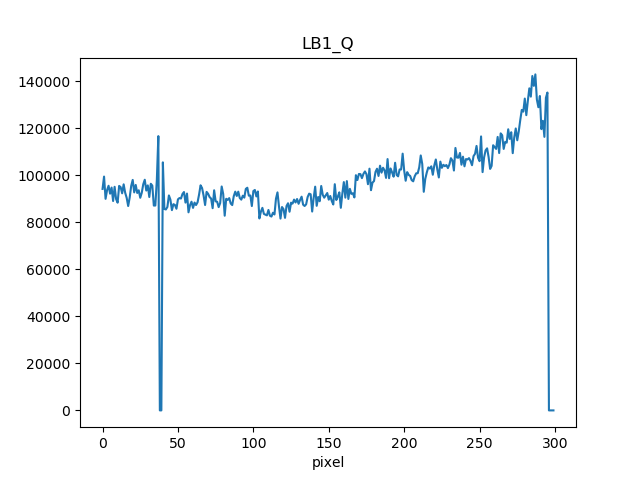

Text(0.5, 1.0, 'LB1_Q')

In [10]:
XES_LB1_Si = np.sum(total_LB1_Si,axis=0)
print(XES_LB1_Si.size)
print(total_LB1_Si.shape)

plt.figure()
plt.plot(XES_LB1_Si)
plt.xlabel('pixel')
plt.title('LB1_Si')

XES_LA1_Si = np.sum(total_LA1_Si,axis=0)

plt.figure()
plt.plot(XES_LA1_Si)
plt.xlabel('pixel')
plt.title('LA1_Si')

XES_LB2_Q = np.sum(total_LB2_Q,axis=0)

plt.figure()
plt.plot(XES_LB2_Q)
plt.xlabel('pixel')
plt.title('LB2_Q')

XES_LB1_Q = np.sum(total_LB1_Q,axis=0)

plt.figure()
plt.plot(XES_LB1_Q)
plt.xlabel('pixel')
plt.title('LB1_Q')
